In [1]:
GMAT_PATH = '/home/daniel/gmat/GMAT/R2022a/'
import sys
sys.path.append(f'{GMAT_PATH}/api/')
from load_gmat import *

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

from astropy.time import Time

import pathlib

# Tianwen-1 clock epoch
epoch = np.datetime64('2015-12-31T16:00:00', 'us')

In [2]:
mars_fixed = gmat.Construct('CoordinateSystem', 'MarsFixed', 'Mars', 'BodyFixed')
mars_inertial = gmat.Construct('CoordinateSystem', 'MarsInertial', 'Mars', 'BodyInertial')

csConverter = gmat.CoordinateConverter()

tw1 = gmat.Construct('Spacecraft', 'Tianwen-1')

tw1.SetField('DateFormat', 'UTCModJulian')
tw1.SetField('CoordinateSystem', 'MarsInertial')
tw1.SetField('DisplayStateType', 'Cartesian')

fm = gmat.Construct('ForceModel', 'MarsFM')
fm.SetField('CentralBody', 'Mars')
grav = gmat.Construct('GravityField')
grav.SetField('BodyName', 'Mars')
grav.SetField('Degree', 8)
grav.SetField('Order', 8)
grav.SetField('PotentialFile', 'GMM2B.cof')
sungrav = gmat.Construct('PointMassForce')
sungrav.SetField('BodyName', 'Sun')
fm.AddForce(grav)
fm.AddForce(sungrav)

prop = gmat.Construct('Propagator', 'MarsProp')
pd78 = gmat.Construct('PrinceDormand78', 'MarsPD78')
prop.SetReference(pd78)
prop.SetReference(fm)
prop.AddPropObject(tw1)

gmat.Initialize()
prop.PrepareInternals()
pd78 = prop.GetPropagator()

rvIn  = gmat.Rvector6()
rvOut = gmat.Rvector6()

In [3]:
def open_tm(path, sel = slice(None)):
    with open(path) as f:
        tm_lines = f.readlines()[1:]
    tm_t = np.array([epoch + np.timedelta64(int(a.split()[0].lstrip('[').rstrip(']'), 16) * 100, 'us')
            for a in tm_lines])
    tm_x = np.array([[float(x) for x in a.split()[3:]] for a in tm_lines])
    return tm_t, tm_x

In [4]:
tm_folder = pathlib.Path('tianwnen-telemetry')

# The [2:] here is used to skip 20211107 and 20211108
tms = [open_tm(f) for f in
       list(sorted(tm_folder.glob('202111*202111*/*statevectors*txt'))[2:])
        + sorted(tm_folder.glob('202112*/*statevectors*txt'))
        + sorted(tm_folder.glob('2022*/*statevectors*txt'))
        + sorted(tm_folder.glob('2023*/*statevectors*txt'))
        + sorted(tm_folder.glob('2024*/*statevectors*txt'))
      ]
tm_t = np.concatenate([a[0] for a in tms if a[0].size])
tm_x = np.concatenate([a[1] for a in tms if a[1].size])

# remove invalid data
invalid = np.sum(tm_x**2, axis=1) == 0
tm_t = tm_t[~invalid]
tm_x = tm_x[~invalid]

mjds = Time(tm_t).jd - 2430000.0

In [5]:
t_prop = []
x_prop = []
flag_sv = []

threshold = 60 / (3600 * 24)
prop_step = 32

for j in range(mjds.size - 1):
    t_prop.append(mjds[j])
    x_prop.append(tm_x[j])
    flag_sv.append(True)
    
    tw1.SetField('Epoch', str(mjds[j]))
    for a,c in zip(tm_x[j], ['X','Y','Z','VX','VY','VZ']):
        tw1.SetField(c, a)
    prop.PrepareInternals()
    
    while t_prop[-1] < mjds[j+1] - threshold:
        pd78.Step(prop_step)
        pd78.UpdateSpaceObject()
        t_prop.append(tw1.GetEpoch())
        x_prop.append(tw1.GetCartesianState().GetDataVector())
        flag_sv.append(False)
        
t_prop = np.array(t_prop)
x_prop = np.array(x_prop)
flag_sv = np.array(flag_sv)

In [6]:
x_prop_fixed = np.empty_like(x_prop)
mjd = gmat.A1Mjd()
for j in range(t_prop.size):
    t = mjd.UtcMjdToA1Mjd(t_prop[j])
    rvIn.Set(*x_prop[j])
    csConverter.Convert(t, rvIn, mars_inertial, rvOut, mars_fixed)
    x_prop_fixed[j] = rvOut.GetDataVector()

In [7]:
lon = np.rad2deg(np.arctan2(x_prop_fixed[:,1], x_prop_fixed[:,0]))
r = np.sqrt(np.sum(x_prop_fixed[:,:3]**2, axis = 1))
lat = np.rad2deg(np.arcsin(x_prop_fixed[:,2]/r))
equator = scipy.signal.argrelextrema(np.abs(lat), np.less)[0]
periapsis = scipy.signal.argrelextrema(r, np.less)[0]
periapsis = periapsis[r[periapsis] < 4000]
apoapsis = scipy.signal.argrelextrema(r, np.greater)[0]
apoapsis = apoapsis[r[apoapsis] > 13500]
time = Time(t_prop + 2430000.0, format = 'jd')

In [8]:
sma = (r[periapsis] + r[apoapsis][:len(periapsis)])/2
ecc = (r[apoapsis][:len(periapsis)] - r[periapsis])/(2*sma)

n = np.cross(x_prop[:, :3], x_prop[:, 3:])
n /= np.sqrt(np.sum(n**2, axis=1))[:, np.newaxis]
incl = np.rad2deg(np.arccos(n[:, 2]))

In [9]:
Time(t_prop[-1] + 2430000.0, format = 'jd').datetime

datetime.datetime(2024, 12, 20, 23, 27, 57, 571481)

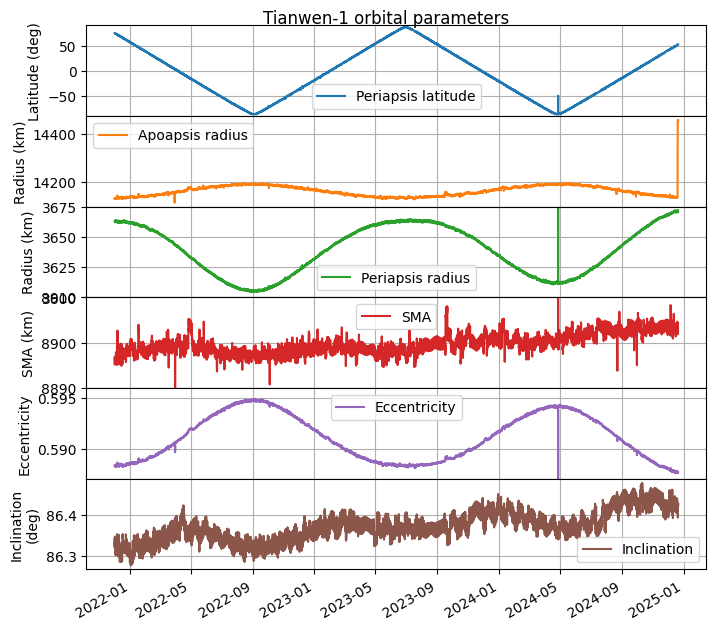

In [10]:
fig, axs = plt.subplots(6, 1, figsize = (8, 8), facecolor = 'w', sharex=True)
axs[0].plot(Time(t_prop[periapsis] + 2430000.0, format = 'jd').datetime,
            lat[periapsis], color='C0', label='Periapsis latitude')
axs[0].set_ylabel('Latitude (deg)')
axs[0].set_ylim((-90, 90))
axs[1].plot(Time(t_prop[apoapsis] + 2430000.0, format = 'jd').datetime,
            r[apoapsis], color='C1', label='Apoapsis radius')
axs[1].set_ylabel('Radius (km)')
axs[2].plot(Time(t_prop[periapsis] + 2430000.0, format = 'jd').datetime,
            r[periapsis], color='C2', label='Periapsis radius')
axs[2].set_ylabel('Radius (km)')
axs[2].set_ylim(3600, 3675)
axs[3].plot(Time(t_prop[periapsis] + 2430000.0, format = 'jd').datetime,
            sma, color='C3', label='SMA')
axs[3].set_ylabel('SMA (km)')
axs[3].set_ylim(8890, 8910)
axs[4].plot(Time(t_prop[periapsis] + 2430000.0, format = 'jd').datetime,
            ecc, color='C4', label='Eccentricity')
axs[4].set_ylabel('Eccentricity')
axs[4].set_ylim(0.587, 0.596)
axs[5].plot(Time(t_prop + 2430000.0, format = 'jd').datetime, incl,
            color='C5', label='Inclination')
axs[5].set_ylabel('Inclination\n(deg)')
for ax in axs:
    ax.grid()
    ax.legend()
plt.subplots_adjust(hspace=0)
plt.suptitle('Tianwen-1 orbital parameters', y=0.9)
fig.autofmt_xdate();

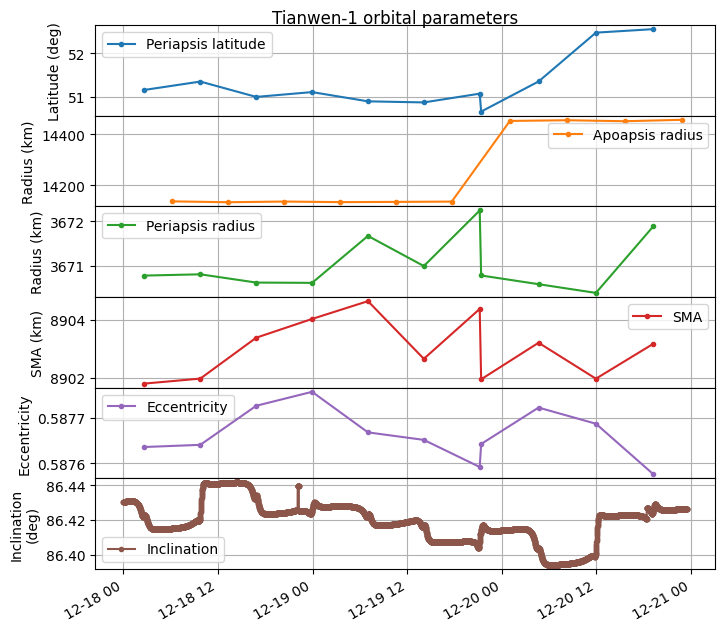

In [11]:
tslice = (Time('2024-12-18'), Time('2024-12-22'))
fig, axs = plt.subplots(6, 1, figsize = (8, 8), facecolor = 'w', sharex=True)
tax = Time(t_prop[periapsis] + 2430000.0, format = 'jd')
tsel = (tax >= tslice[0]) & (tax <= tslice[1])
axs[0].plot(tax[tsel].datetime,
            lat[periapsis][tsel], '.-', color='C0', label='Periapsis latitude')
axs[0].set_ylabel('Latitude (deg)')
tax = Time(t_prop[apoapsis] + 2430000.0, format = 'jd')
tsel = (tax >= tslice[0]) & (tax <= tslice[1])
axs[1].plot(tax[tsel].datetime,
            r[apoapsis][tsel], '.-', color='C1', label='Apoapsis radius')
axs[1].set_ylabel('Radius (km)')
tax = Time(t_prop[periapsis] + 2430000.0, format = 'jd')
tsel = (tax >= tslice[0]) & (tax <= tslice[1])
axs[2].plot(tax[tsel].datetime,
            r[periapsis][tsel], '.-', color='C2', label='Periapsis radius')
axs[2].set_ylabel('Radius (km)')
axs[3].plot(tax[tsel].datetime,
            sma[tsel], '.-', color='C3', label='SMA')
axs[3].set_ylabel('SMA (km)')
axs[4].plot(tax[tsel].datetime,
            ecc[tsel], '.-', color='C4', label='Eccentricity')
axs[4].set_ylabel('Eccentricity')
tax = Time(t_prop + 2430000.0, format = 'jd')
tsel = (tax >= tslice[0]) & (tax <= tslice[1])
axs[5].plot(tax[tsel].datetime, incl[tsel], '.-',
            color='C5', label='Inclination')
axs[5].set_ylabel('Inclination\n(deg)')
for ax in axs:
    ax.grid()
    ax.legend()
plt.subplots_adjust(hspace=0)
plt.suptitle('Tianwen-1 orbital parameters', y=0.9)
fig.autofmt_xdate();

In [12]:
# Rate of change of periapsis latitude in deg/day
np.polyfit(t_prop[periapsis][:900], lat[periapsis][:900], 1)

array([-5.98060960e-01,  1.77473532e+04])

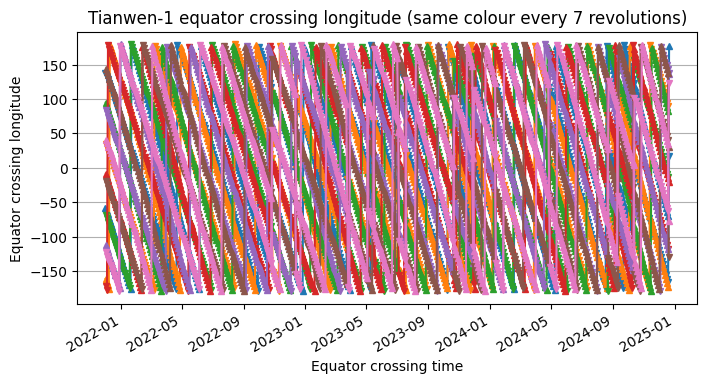

In [13]:
plt.figure(figsize = (8, 4), facecolor = 'w')
for j in range(14):
    color = j//2
    marker = 'v' if j % 2 == 0 else '^'
    plt.plot(Time(t_prop[equator][j::14] + 2430000.0, format = 'jd').datetime,
             lon[equator[j::14]], marker + '-', markersize=5, color=f'C{color}',
             label = 'Equator crossing longitude')
plt.title('Tianwen-1 equator crossing longitude (same colour every 7 revolutions)')
plt.ylabel('Equator crossing longitude')
plt.xlabel('Equator crossing time')
plt.grid(axis='y')
plt.gcf().autofmt_xdate();